Initializing eigensolver data
Computing 5 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 20 x 300 x 400.
Solving for 5 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 15, 0)
     (0, 0, 20)
Cell volume = 300
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.0666667, -0)
     (0, -0, 0.05)
Geometric objects:
     block, center = (0,0,0)
          size (1,1.68033,0.372951)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,1.22459,-0.745902)
          size (0.4,0.4,1.11885)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-1.22459,-0.745902)
          size (0.4,0.4,1.11885)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.745902)
          size (0.4,2.04918,1.11885)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-4.30533)
          size (1,10,6)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 5 and 17 object no

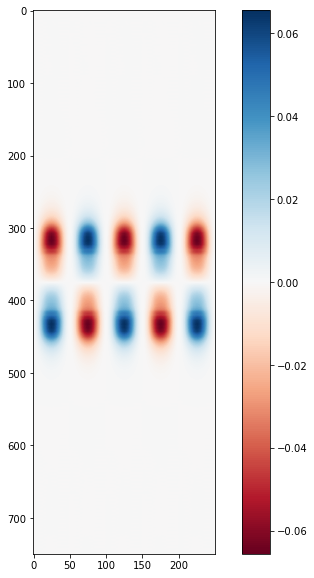

1
real part range: -0.261478 .. 0.261478
imag part range: -0.110505 .. 0.110505


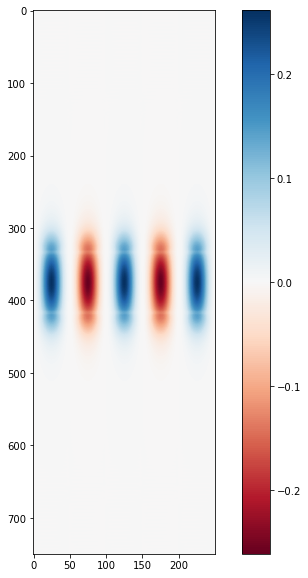

2
real part range: -0.0233935 .. 0.0233935
imag part range: -0.0265328 .. 0.0265328


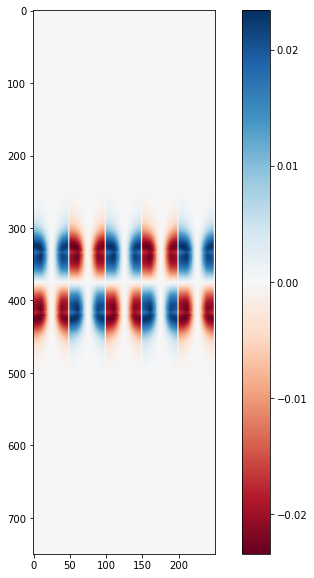

3
real part range: -0.209926 .. 0.209926
imag part range: -0.0923305 .. 0.0923305


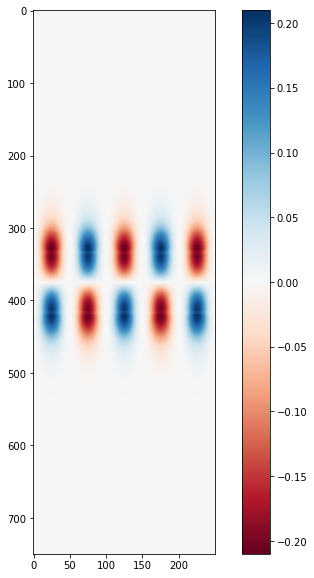

4


In [1]:
####################################################
##### Field Programmable Spin Arrays for Scalable Quantum Repeaters
##### Author: Hanfeng Wang and Kevin C. Chen
##### Date: 12-23-2022
##### 
####################################################

from matplotlib import pyplot as plt
import numpy as np
import math
#import scipy.io

# load the Meep and MPB modules in Python
import meep as mp
from meep import mpb

c =  299792458
SiV_omega = (1e-12)*c/(737e-9) # in THz


dx = 0.005
### define device parameters (normalized to a=1)
# note: these numbers can be arbitrary
#a = 0.186

a = 0.244
h = 0.091/a
#h1 = 0.35/a
h2 = 0.273/a
W1 = 0.41/a


air = 1.0
dmd = 2.4
hfo = 1.9
aln = 2.15
kcl = 1.49

#X = 1
X = 1 #0.2*b
Y = 15
Z = 20#5


X2 = 1/2 - 1/10
#Y1 = 0.2/a/1.1
####################################################
### define alligator geometry verticies (one periodicity)
xs = np.linspace(-X/2,X/2,int(1/dx))



####################################################

outputfields = True
outputepsilon = False
midgapfreq = False
runsim = False
#simtype = "TE"




geometry = [mp.Block(mp.Vector3(X,W1,h), center=mp.Vector3(0,0,0), material=mp.Medium(index=dmd)),
#            mp.Block(mp.Vector3(2*X2,W1,h1), center=mp.Vector3(0,0,h/2+h1/2), material=mp.Medium(index=kcl)),
            mp.Block(mp.Vector3(X2,X2,h2), center=mp.Vector3(0,0.25/a+X2/2,-h/2-h2/2), material=mp.Medium(index=1.78)),
            mp.Block(mp.Vector3(X2,X2,h2), center=mp.Vector3(0,-0.25/a-X2/2,-h/2-h2/2), material=mp.Medium(index=1.78)),
            mp.Block(mp.Vector3(X2,0.5/a,h2), center=mp.Vector3(0,0,-h/2-h2/2), material=mp.Medium(index=aln)),
            mp.Block(mp.Vector3(X,10,6), center=mp.Vector3(0,0,-3-h/2-h2), material=mp.Medium(index=1.45))]

if midgapfreq:
    midgaps = []
ms = mpb.ModeSolver(                    
                        geometry_lattice=mp.Lattice(size=(X,Y,Z)),
                        geometry=geometry,
                        default_material=mp.Medium(index=air),
                        k_points=mp.interpolate(21, [mp.Vector3(0.4,0,0), mp.Vector3(0.5,0,0)]),
                        resolution=20,
                        # resolution=12,
                        num_bands=5
                        )

# if midgapfreq:
#     midgaps.append((1e-12)*(c/(a*1e-6))*abs(freqs[0][1]+freqs[0][0])/2.)

# plt.figure(figsize=(10,8))
# plt.plot(Zs, midgaps, "k-")
# # plt.plot(resolutions, midgaps, "k-")
# # plt.xlabel("resolutions")
# plt.xlabel("Z")
# plt.ylabel("Frequency (THz)")
# plt.title("Midgap freq")
# plt.show()
if runsim:
    ms.run()
    freqs = ms.all_freqs

    ks = [k.x for k in ms.k_points] # kx wavevector
    plt.figure(figsize=(10,8))
    plt.plot(ks, (1e-12)*(c/(a*1e-6))*freqs, "k-")
    plt.plot([ks[0],ks[-1]],[NV_omega,NV_omega],"k:")
    plt.plot([ks[0],ks[-1]],[ks[0]*c*1e-12/(a*1e-6),ks[-1]*c*1e-12/(a*1e-6)],"k:")
    plt.xlabel("$k_x (2\pi/a)$")
    plt.ylabel("$f$ (THz)")
    plt.title('simtype')
    plt.show()


### Plot mode fields
if outputfields:

    ms.k_points = [mp.Vector3(0.5)]
    ms.run(mpb.fix_efield_phase)
    # ms.run_te_yodd(mpb.fix_efield_phase)
    # ms.run_tm_yeven(mpb.fix_efield_phase)

    md = mpb.MPBData(x=5, resolution=50)
    z0 = int(ms.resolution[0]*Z/2.)
    for i in range(1,5):
        ez1 = np.real(md.convert(ms.get_efield(i,bloch_phase=False)[:,:,z0,2]))
        maxabsz1 = np.max(abs(ez1))
        plt.figure(figsize=(10,10))
        plt.imshow(ez1.T, cmap='RdBu', vmin=-maxabsz1, vmax=+maxabsz1)
        plt.colorbar()
        plt.show()
        print(i)
    
    
### Plot epsilon to check device geometry
if outputepsilon:
    ms.init_params(mp.NO_PARITY,False)
    plt.figure(figsize=(10,10))
    md = mpb.MPBData(x=1, resolution=50)
    A = md.convert(ms.get_epsilon())
    plt.show()


    #eps = ms.get_epsilon()
    #from mayavi import mlab
    #s = mlab.contour3d(eps, colormap="YlGnBu")
    #mlab.show()

real part range: -0.876648 .. 0.876648
imag part range: -0.000276427 .. 0.000276427


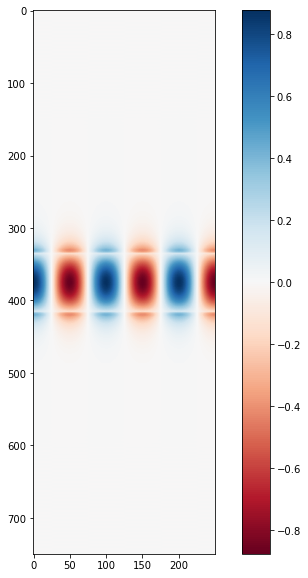

2


In [4]:

    md = mpb.MPBData(x=5, resolution=50)
    z0 = int(ms.resolution[0]*Z/2.)
    ez1 = np.real(md.convert(ms.get_efield(3,bloch_phase=True)[:,:,z0,1]))
    maxabsz1 = np.max(abs(ez1))
    plt.figure(figsize=(10,10))
    plt.imshow(ez1.T, cmap='RdBu', vmin=-maxabsz1, vmax=+maxabsz1)
    plt.colorbar()
    plt.show()
    print(i)

In [5]:
np.set_printoptions(threshold=np.inf)
ez1

array([[ 2.40409320e-05,  3.91864773e-06, -1.62036365e-05,
        -1.61194536e-05,  4.17119637e-06,  2.44618464e-05,
         4.68459048e-06, -1.50926654e-05, -1.50032668e-05,
         4.95278618e-06,  2.49088392e-05,  5.46537100e-06,
        -1.39780972e-05, -1.38100696e-05,  5.96945386e-06,
         2.57489773e-05,  5.62831932e-06, -1.44923386e-05,
        -1.42534880e-05,  6.34487116e-06,  2.69432303e-05,
         6.65895769e-06, -1.36253150e-05, -1.37651829e-05,
         6.23935392e-06,  2.62438907e-05,  5.81515718e-06,
        -1.46135764e-05, -1.47315299e-05,  5.46129652e-06,
         2.56541230e-05,  5.69389205e-06, -1.42663389e-05,
        -1.38009555e-05,  7.09004218e-06,  2.79810398e-05,
         7.51905798e-06, -1.29429239e-05, -1.27417733e-05,
         8.12250966e-06,  2.89867926e-05,  7.16245151e-06,
        -1.46618896e-05, -1.46222027e-05,  7.28151235e-06,
         2.91852274e-05,  7.76281459e-06, -1.36595982e-05,
        -1.38237648e-05,  7.27031470e-06,  2.83643942e-0

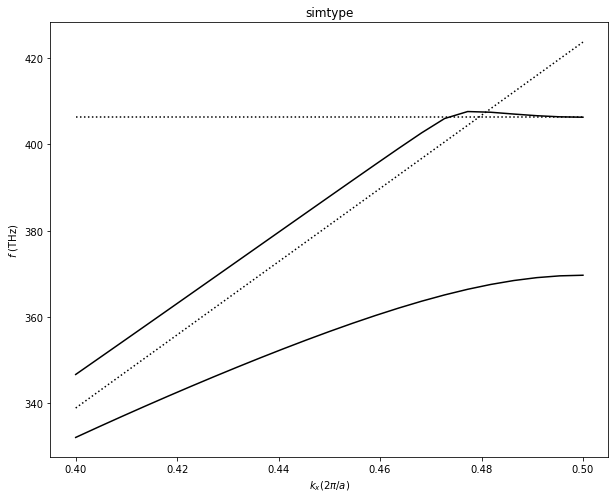

In [9]:
NV_omega = (1e-12)*2.997e8/(737.5e-9)
plt.figure(figsize=(10,8))
plt.plot(ks, (1e-12)*(c/(a*1e-6))*freqs[:,0], "k-")
plt.plot(ks, (1e-12)*(c/(a*1e-6))*freqs[:,2], "k-")
plt.plot([ks[0],ks[-1]],[NV_omega,NV_omega],"k:")
#plt.plot([ks[0],ks[-1]],[ks[0]*c*1e-12/(a*1e-6),ks[-1]*c*1e-12/(a*1e-6)],"k:")
plt.plot([ks[0],ks[-1]],[ks[0]*c*1e-12/(a*1e-6)/1.45,ks[-1]*c*1e-12/(a*1e-6)/1.45],"k:")
plt.xlabel("$k_x (2\pi/a)$")
plt.ylabel("$f$ (THz)")
plt.title('simtype')
plt.show()

In [12]:
freqs[:,0]


array([0.27032051, 0.27230947, 0.27426624, 0.27619118, 0.27808401,
       0.27994389, 0.28176938, 0.28355838, 0.28530807, 0.28701475,
       0.28867374, 0.29027914, 0.29182364, 0.29329819, 0.29469174,
       0.29599089, 0.29717973, 0.29823983, 0.29915056, 0.29989015,
       0.30043736, 0.30077403, 0.30088776])

In [13]:
freqs[:,2]

array([0.2821879 , 0.28521796, 0.28825479, 0.29129704, 0.29434358,
       0.29739341, 0.30044565, 0.30349939, 0.3065537 , 0.30960742,
       0.31265917, 0.31570682, 0.31874708, 0.32177395, 0.32477474,
       0.32771434, 0.33042255, 0.33173822, 0.33160623, 0.3312643 ,
       0.33095129, 0.33074144, 0.3306681 ])

In [14]:
ks

[0.4,
 0.40454545454545454,
 0.4090909090909091,
 0.41363636363636364,
 0.4181818181818182,
 0.42272727272727273,
 0.4272727272727273,
 0.4318181818181818,
 0.4363636363636364,
 0.4409090909090909,
 0.44545454545454544,
 0.45,
 0.4545454545454546,
 0.4590909090909091,
 0.4636363636363636,
 0.4681818181818182,
 0.4727272727272727,
 0.4772727272727273,
 0.4818181818181818,
 0.48636363636363633,
 0.4909090909090909,
 0.4954545454545455,
 0.5]

In [ ]:
(1e-12)*(c/(a*1e-6))*freqs

In [ ]:
for i in range(1,5):
    ez1 = np.real(md.convert(ms.get_efield(i,bloch_phase=False)[:,:,z0,2]))
    maxabsz1 = np.max(abs(ez1))
    plt.figure(figsize=(10,10))
    plt.imshow(ez1.T, cmap='RdBu', vmin=-maxabsz1, vmax=+maxabsz1)
    plt.colorbar()
    plt.show()
    print(i)

In [ ]:
ey1.shape

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
ey1[1:50,150:600]

##### ks = [k.x for k in ms.k_points] # kx wavevector
plt.figure(figsize=(10,8))
plt.plot(ks, (1e-12)*(c/(a*1e-6))*freqs, "k-")
plt.plot([ks[0],ks[-1]],[NV_omega,NV_omega],"k:")
plt.plot([ks[0],ks[-1]],[ks[0]*c*1e-12/(a*1e-6),ks[-1]*c*1e-12/(a*1e-6)],"k:")
plt.plot([ks[0],ks[-1]],[ks[0]*c*1e-12/(a*1e-6)/1.45,ks[-1]*c*1e-12/(a*1e-6)/1.45],"k:")
plt.xlabel("$k_x (2\pi/a)$")
plt.ylabel("$f$ (THz)")
plt.title('simtype')
plt.show()

In [ ]:
(1e-12)*c/(637e-9)

In [ ]:
(1e-12)*(c/(a*1e-6))*freqs[:,2]

In [ ]:
ks

In [ ]:
c/((470.6357359-470.62455397)*1e12*2*3.1415926/(2*3.1415926/(0.184*1e-6)*(0.5-0.49)/42))

In [ ]:
(1e-12)*(3e8/(1*1e-6))*0.5